In [2]:
!pip install --quiet tinydb
!pip install --upgrade --quiet numpy

You are using pip version 10.0.1, however version 20.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 10.0.1, however version 20.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
%matplotlib inline
from tinydb import TinyDB
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
from sklearn.cluster import AffinityPropagation
from collections import Counter
import seaborn as sns

In [4]:
records_taken_together = TinyDB('db_parsed_taken_together.json').all()
records_pd_taken_together = pd.DataFrame(records_taken_together).drop_duplicates()
print('number of unique records', records_pd_taken_together.shape)

number of unique records (385227, 2)


#  Process data
Convert a collection of generic_name documents as defined in `https://open.fda.gov/apis/drug/label/searchable-fields` to a matrix of token counts.

In [5]:
vectoriser_taken_together = CountVectorizer(min_df=5, max_df=0.2, 
                                            binary=True, 
                                            token_pattern=r"(?u)[\w -]+", 
                                            dtype=np.bool)
matrix_taken_together= vectoriser_taken_together.fit_transform(records_pd_taken_together['generic_name'])
X_taken_together = matrix_taken_together.toarray()
print('Drugs count matrix size:', X_taken_together.shape)

Drugs count matrix size: (385227, 1674)


In [6]:
ind_taken_together = np.where(X_taken_together.sum(1)>3)
x_taken_together_filt = X_taken_together[ind_taken_together[0],]
print('Filtered drugs count matrix size:', x_taken_together_filt.shape)
dist_taken_together = pairwise_distances(x_taken_together_filt.T, metric='jaccard')

Filtered drugs count matrix size: (19991, 1674)


In [7]:
dist_taken_together_norm = np.nan_to_num(dist_taken_together, nan=1.0)

#  Clustering
Use Affinity Propagation (`https://science.sciencemag.org/content/315/5814/972`) to identify clusters of drugs that tend to be taken together

In [45]:
clustering = AffinityPropagation(affinity='precomputed').fit_predict(-dist_taken_together_norm)

In [46]:
clustering

array([131, 166,   0, ..., 321, 246, 185])

#  Results
Use clustering and cluster distance threshold to identify drugs that tend to be taken together

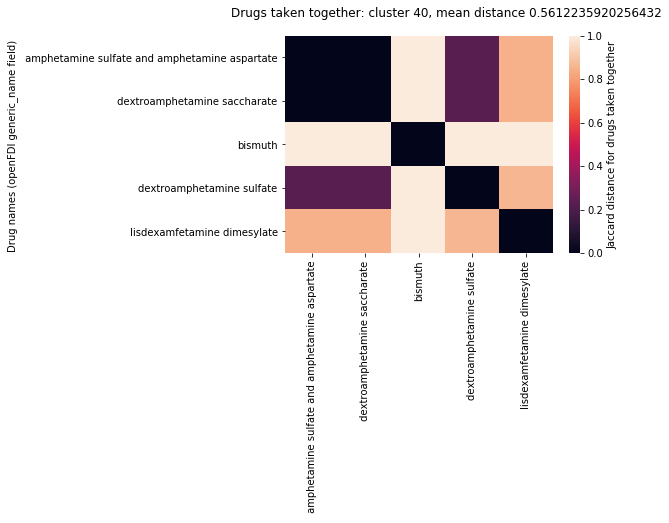

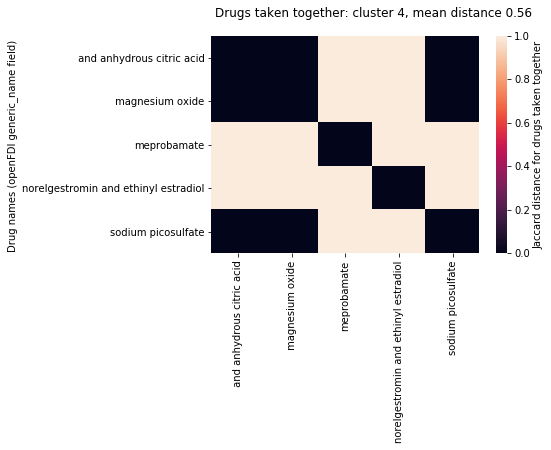

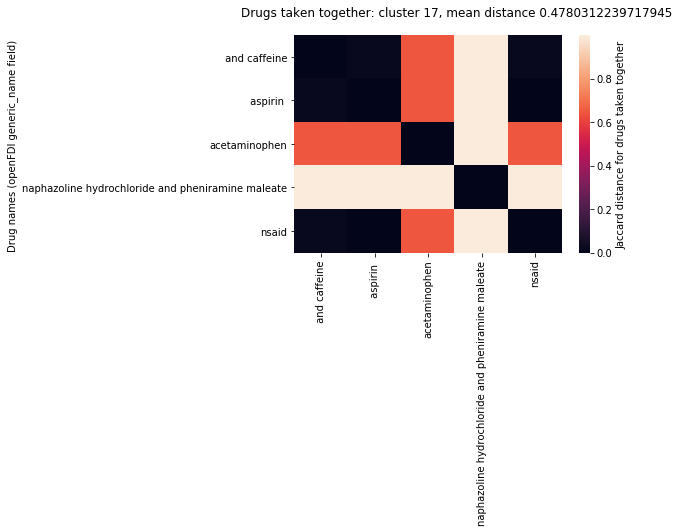

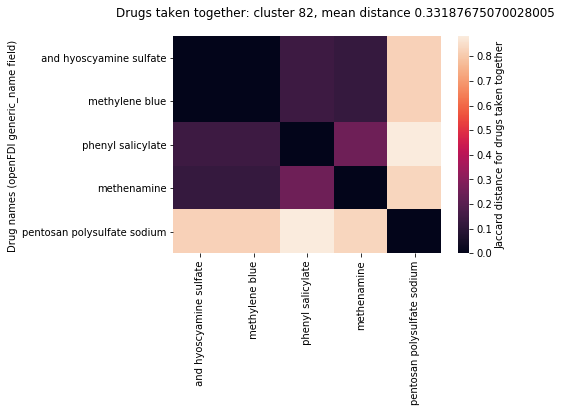

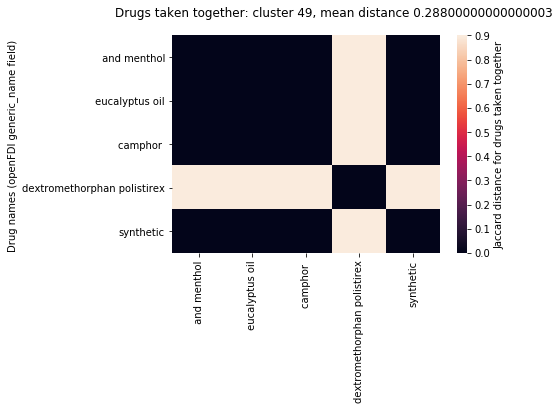

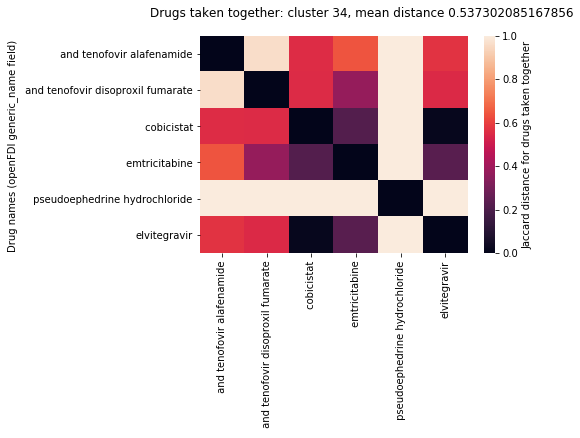

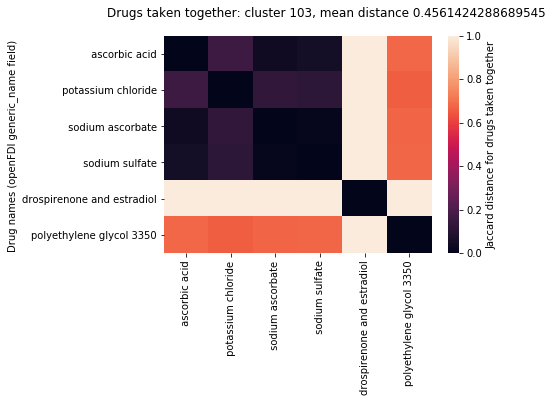

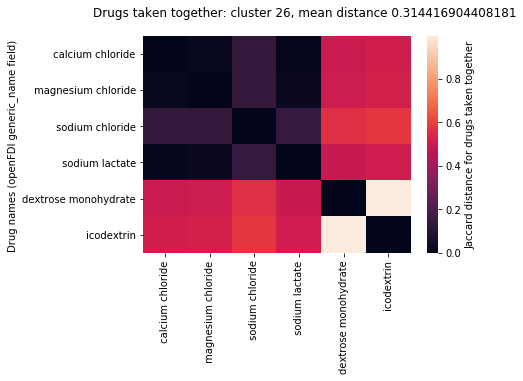

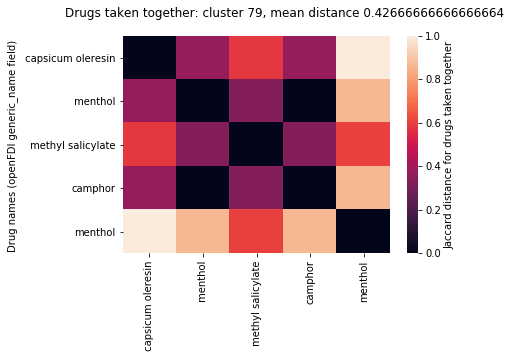

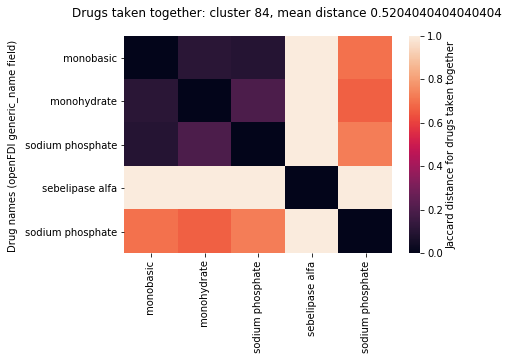

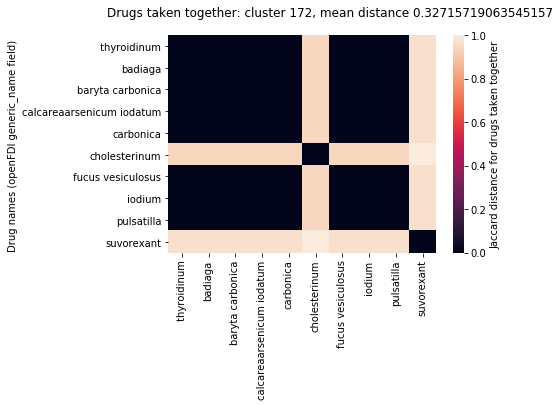

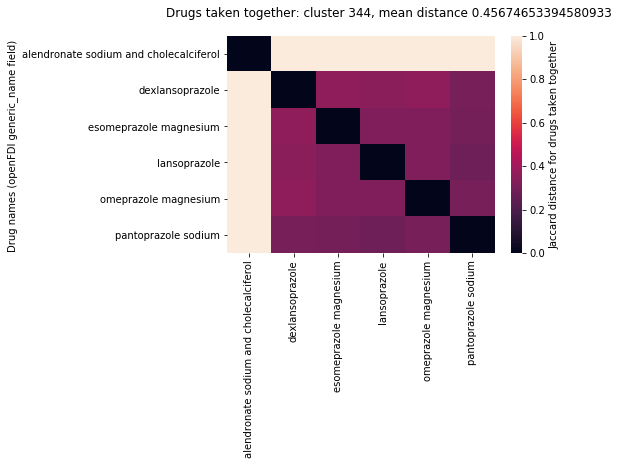

In [50]:
clusters = []
drug_names = vectoriser_taken_together.get_feature_names()
for cluster_index, occurence in dict(Counter(clustering)).items():
    ind = np.where(clustering==cluster_index)[0]
    dist_mat = dist_taken_together_norm[np.ix_(ind, ind)] 
    mean_dist = dist_mat.mean()
    if mean_dist < 0.6 and occurence > 4 and mean_dist > 0:
        drug_name = np.array(drug_names)[ind]
        cluster = {}
        cluster['cluster_id'] = cluster_index
        cluster['drugs'] = ' '.join(list(drug_name))
        cluster['mean_dist'] = mean_dist
        clusters.append(cluster)
        fig = plt.figure()
        fig.suptitle(f'Drugs taken together: cluster {cluster_index}, mean distance {mean_dist}')
        sns.heatmap(dist_mat, xticklabels=drug_name, yticklabels=drug_name, cbar_kws={'label': 'Jaccard distance for drugs taken together'})
        plt.ylabel('Drug names (openFDI generic_name field) ')

In [51]:
clusters_pd = pd.DataFrame(clusters)

In [52]:
pd.set_option('display.max_colwidth', 130)
clusters_pd

,cluster_id,drugs,mean_dist
0,40,amphetamine sulfate and amphetamine aspartate dextroamphetamine saccharate bismuth dextroamphetamine sulfate lisdexamfetamin...,0.561224
1,4,and anhydrous citric acid magnesium oxide meprobamate norelgestromin and ethinyl estradiol sodium picosulfate,0.560000
2,17,and caffeine aspirin acetaminophen naphazoline hydrochloride and pheniramine maleate nsaid,0.478031
3,82,and hyoscyamine sulfate methylene blue phenyl salicylate methenamine pentosan polysulfate sodium,0.331877
4,49,and menthol eucalyptus oil camphor dextromethorphan polistirex synthetic,0.288000
5,34,and tenofovir alafenamide and tenofovir disoproxil fumarate cobicistat emtricitabine pseudoephedrine hydrochloride elvite...,0.537302
6,103,ascorbic acid potassium chloride sodium ascorbate sodium sulfate drospirenone and estradiol polyethylene glycol 3350,0.456142
7,26,calcium chloride magnesium chloride sodium chloride sodium lactate dextrose monohydrate icodextrin,0.314417
8,79,capsicum oleresin menthol methyl salicylate camphor menthol,0.426667
9,84,monobasic monohydrate sodium phosphate sebelipase alfa sodium phosphate,0.520404


In [53]:
clusters_pd.to_csv('drugs_taken_together.csv')